In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import h5py
from IPython.display import display
import numpy as np
from os.path import join as pj
import pandas as pd
import random
import sys
import torch
from tqdm import tqdm
import visdom

# Logger
from IO.logger import Logger
# Data Augument
from dataset.classification.loader import create_validation_split, load_validation_data, create_train_data, create_train_data_DCL
# RCM
from dataset.classification.region_confusion_mechanism import region_confusion_mechanism
# Model
from model.resnet.utils import define_weight
from model.resnet.predict import test_classification
# Evaluation
from evaluation.classification.evaluate import accuracy, confusion_matrix
# Statistics
from evaluation.classification.statistics import compute_each_size_df, compute_all_size_df
# Visualize
from evaluation.classification.visualize import create_confusion_matrix, plot_df_distrib_size

# Train Config

In [3]:
class args:
    # experiment_name
    experiment_name = "resnet50_b20_r45_lr1e-5_crossvalid_freeze"
    # data split
    train_ratio = 0.8 # unused parameters
    test_ratio = 0.2
    # paths
    all_data_path = "/home/tanida/workspace/Insect_Phenology_Detector/data/all_classification_data/classify_insect_std_aquatic"
    model_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/output_model/classification/ResNet101", experiment_name)
    figure_root = pj("/home/tanida/workspace/Insect_Phenology_Detector/figure/classification/ResNet101", experiment_name)
    # class names to visualize
    #labels =  ['Aquatic_insects', 'Other_insects']
    labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
               'Lepidoptera', 'Plecoptera', 'Trichoptera']
    #labels =  ['Diptera', 'Ephemeridae', 'Ephemeroptera', 
    #           'Lepidoptera', 'Plecoptera', 'Trichoptera', 
    #           'Coleoptera', 'Hemiptera', 'medium insect', 'small insect']
    # train config
    model_name = "ResNet50" # choice ["ResNet18", "ResNet34", "ResNet50", "ResNet101"]
    use_DCL = False
    division_number = 7
    neighborhood_range = 1
    cls_weight = 1
    dest_weight = 10
    coord_weight = 0.1
    bs = 20
    lr = 1e-5
    nepoch = 40
    rotate = 45
    pretrain = True
    freeze = True
    # test config
    save_fig = True
    save_df = True
    # visdom
    visdom = False
    port = 8097

# Load Model

In [4]:
# Model
if args.model_name=="ResNet18":
    from model.resnet.resnet18 import ResNet18
elif args.model_name=="ResNet34":
    from model.resnet.resnet34 import ResNet34
elif args.model_name=="ResNet50":
    from model.resnet.resnet50 import ResNet50
elif args.model_name=="ResNet101":
    from model.resnet.resnet101 import ResNet101
else:
    print("error! write correct model name!")

# Train

In [5]:
def train(model, xtr, ytr, bs=20, lr=1e-5, nepoch=40, visdom=False):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    
    # define optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            opt.zero_grad()
            out = model(x)
            loss = ce(out, y)
            total_loss += loss.item()
            loss.backward()
            opt.step()
        
        model.training = False
        te_acc = accuracy(model, xte, yte, bs)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
        sys.stdout.write("\rtotal_loss=%f, te_acc=%f" % (total_loss,te_acc))
        sys.stdout.flush()
        

def train_DCL(model, xtr, ytr, target_dest_or_not, target_coordinate, bs=20, lr=1e-5, nepoch=40, visdom=False, cls_weight=1, dest_weight=10, coord_weight=0.1):
    # calculate counts and count_sum
    _, counts = np.unique(ytr, return_counts=True)
    counts_sum = counts.sum()
    
    # define weight and create loss function
    cls_ce = torch.nn.CrossEntropyLoss(define_weight(counts))
    dest_ce = torch.nn.CrossEntropyLoss()
    coord_l1 = torch.nn.L1Loss()
    
    # define optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    # set model train mode
    model.train()
    
    t = tqdm(range(nepoch),leave=False)
    # training
    for epoch in t:
        sum_cls_loss = 0
        sum_dest_loss = 0
        sum_coord_loss = 0
        total_loss = 0
        index = random.sample(range(counts_sum),counts_sum)
        t.set_description("epoch=%s" % (epoch))
        for idx in range(0,counts_sum-bs,bs):
            idx = index[idx:idx+bs]
            x = xtr[idx].cuda()
            y = ytr[idx].cuda()
            sample_dest_or_not = target_dest_or_not[idx].cuda()
            sample_coordinate = target_coordinate[idx].cuda()
            opt.zero_grad()
            out, predict_loc, dest_or_not = model(x)
            cls_loss = cls_ce(out, y) * cls_weight
            dest_loss = dest_ce(dest_or_not, sample_dest_or_not) * dest_weight
            coord_loss = coord_l1(predict_loc, sample_coordinate) * coord_weight
            loss = cls_loss + dest_loss + coord_loss
            sum_cls_loss += cls_loss.item()
            sum_dest_loss += dest_loss.item()
            sum_coord_loss += coord_loss.item()
            total_loss += loss.item()
            loss.backward()
            opt.step()
        
        model.training = False
        te_acc = accuracy(model, xte, yte, bs)
        model.training = True
        if visdom:
            visualize(vis, epoch+1, sum_cls_loss, win_cls_loss)
            visualize(vis, epoch+1, sum_dest_loss, win_dest_loss)
            visualize(vis, epoch+1, sum_coord_loss, win_coord_loss)
            visualize(vis, epoch+1, total_loss, win_train_loss)
            visualize(vis, epoch+1, te_acc, win_test_acc)
        sys.stdout.write("\rcls_loss=%f, dest_loss=%f, coord_loss=%f, train_loss=%f, te_acc=%f" % (sum_cls_loss, sum_dest_loss, sum_coord_loss, total_loss, te_acc))
        sys.stdout.flush()

# Set Visdom

In [6]:
if args.visdom:
    # Create visdom
    vis = visdom.Visdom(port=args.port)
    
    """train_loss"""
    win_train_loss = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='train_loss',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    """test_accuracy"""
    win_test_acc = vis.line(
        X=np.array([0]),
        Y=np.array([0]),
        opts=dict(
            title='test_accuracy',
            xlabel='epoch',
            ylabel='loss',
            width=800,
            height=400
        )
    )
    
    if args.use_DCL is True:
        """train_loss"""
        win_cls_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='classification_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )
        win_dest_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='adversarial_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )
        win_coord_loss = vis.line(
            X=np.array([0]),
            Y=np.array([0]),
            opts=dict(
                title='coordinate_loss',
                xlabel='epoch',
                ylabel='loss',
                width=800,
                height=400
            )
        )

In [7]:
def visualize(vis, phase, visualized_data, window):
    vis.line(
        X=np.array([phase]),
        Y=np.array([visualized_data]),
        update='append',
        win=window
    )

### Save args

In [8]:
args_logger = Logger(args)
args_logger.save()

# Cross Validation

In [9]:
model_save_path = pj(args.model_root, "final.pth")
if os.path.exists(args.model_root) is False:
    os.makedirs(args.model_root)
if os.path.exists(args.figure_root) is False:
    os.makedirs(args.figure_root)

In [10]:
valid_num = int(1.0/args.test_ratio)
with h5py.File(args.all_data_path) as f:
    X = f["X"][:]
    Y = f["Y"][:]
_, ntests = np.unique(Y, return_counts=True)
train_idxs, test_idxs = create_validation_split(Y, args.test_ratio)
result = []
for valid_count in range(valid_num):
    xtr, ytr, xte, yte = load_validation_data(X, Y, train_idxs[valid_count], test_idxs[valid_count])
    
    if args.use_DCL is True:
        new_xtr, new_coordinate = region_confusion_mechanism(xtr, division_number=args.division_number, neighborhood_range=args.neighborhood_range)
        xtr = np.concatenate([xtr, new_xtr])
        ytr = np.concatenate([ytr, ytr])
        target_dest_or_not = np.concatenate([np.zeros(ytr.shape), np.ones(ytr.shape)])
        target_coordinate = np.concatenate([new_coordinate, np.asarray([np.arange(args.division_number**2)] * new_coordinate.shape[0])])
        xtr, ytr, target_dest_or_not, target_coordinate = create_train_data_DCL(xtr, ytr, target_dest_or_not, target_coordinate, args.rotate)
    else:
        xtr, ytr = create_train_data(xtr, ytr, args.rotate)
    
    if args.model_name=="ResNet18":
        model = ResNet18(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet34":
        model = ResNet34(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet50":
        model = ResNet50(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    elif args.model_name=="ResNet101":
        model = ResNet101(len(args.labels), use_DCL=args.use_DCL, division_number=args.division_number, pretrain=args.pretrain, freeze=args.freeze, training=True).cuda()
    else:
        print("error! write correct model name!")
    
    if args.use_DCL is True:
        train_DCL(model, xtr, ytr, target_dest_or_not, target_coordinate, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom, cls_weight=args.cls_weight, dest_weight=args.dest_weight, coord_weight=args.coord_weight)
    else:
        train(model, xtr, ytr, bs=args.bs, lr=args.lr, nepoch=args.nepoch, visdom=args.visdom)
            
    torch.save(model.state_dict(), model_save_path)
    
    model.training = False
    matrix = confusion_matrix(model, xte, yte, args.labels, bs=args.bs)
    model.training = True
    df = pd.DataFrame(matrix)
    display(df)
    if valid_count == 0:
        validation_matrix = matrix
        x_all = xte.cpu().numpy()
        y_all = yte.cpu().numpy()
    else:
        validation_matrix += matrix
        x_all = np.concatenate([x_all, xte.cpu().numpy()])
        y_all = np.concatenate([y_all, yte.cpu().numpy()])
    
    result.extend(test_classification(model, xte))

  0%|          | 1/1059 [00:00<03:27,  5.09it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=752.900564, te_acc=0.301887

epoch=1:   2%|▎         | 1/40 [00:21<14:04, 21.66s/it]

total_loss=717.373404, te_acc=0.483019

epoch=2:   5%|▌         | 2/40 [00:41<13:25, 21.20s/it]

total_loss=687.352064, te_acc=0.498113

epoch=3:   8%|▊         | 3/40 [00:58<12:12, 19.80s/it]

total_loss=661.148947, te_acc=0.532075

epoch=4:  10%|█         | 4/40 [01:15<11:22, 18.97s/it]

total_loss=638.769133, te_acc=0.573585

epoch=5:  12%|█▎        | 5/40 [01:31<10:39, 18.27s/it]

total_loss=618.861397, te_acc=0.562264

epoch=6:  15%|█▌        | 6/40 [01:48<10:05, 17.81s/it]

total_loss=600.907946, te_acc=0.584906

epoch=7:  18%|█▊        | 7/40 [02:05<09:35, 17.44s/it]

total_loss=586.349732, te_acc=0.577358

epoch=8:  20%|██        | 8/40 [02:21<09:09, 17.19s/it]

total_loss=573.173131, te_acc=0.566038

epoch=9:  22%|██▎       | 9/40 [02:38<08:48, 17.06s/it]

total_loss=562.337968, te_acc=0.592453

epoch=10:  25%|██▌       | 10/40 [02:55<08:26, 16.89s/it]

total_loss=552.561733, te_acc=0.592453

epoch=11:  28%|██▊       | 11/40 [03:11<08:07, 16.83s/it]

total_loss=541.798070, te_acc=0.603774

epoch=12:  30%|███       | 12/40 [03:28<07:48, 16.74s/it]

total_loss=533.691022, te_acc=0.584906

epoch=13:  32%|███▎      | 13/40 [03:44<07:30, 16.69s/it]

total_loss=524.189316, te_acc=0.588679

epoch=14:  35%|███▌      | 14/40 [04:01<07:14, 16.70s/it]

total_loss=519.334378, te_acc=0.569811

epoch=15:  38%|███▊      | 15/40 [04:18<06:58, 16.74s/it]

total_loss=511.143336, te_acc=0.603774

epoch=16:  40%|████      | 16/40 [04:36<06:49, 17.05s/it]

total_loss=508.452918, te_acc=0.603774

epoch=17:  42%|████▎     | 17/40 [04:57<07:02, 18.35s/it]

total_loss=501.031042, te_acc=0.603774

epoch=18:  45%|████▌     | 18/40 [05:19<07:04, 19.28s/it]

total_loss=495.594153, te_acc=0.626415

epoch=19:  48%|████▊     | 19/40 [05:40<06:59, 19.98s/it]

total_loss=488.903740, te_acc=0.607547

epoch=20:  50%|█████     | 20/40 [06:02<06:47, 20.37s/it]

total_loss=489.058778, te_acc=0.618868

epoch=21:  52%|█████▎    | 21/40 [06:23<06:32, 20.66s/it]

total_loss=481.028284, te_acc=0.607547

epoch=22:  55%|█████▌    | 22/40 [06:44<06:15, 20.88s/it]

total_loss=477.965128, te_acc=0.596226

epoch=23:  57%|█████▊    | 23/40 [07:06<05:57, 21.06s/it]

total_loss=478.765692, te_acc=0.615094

epoch=24:  60%|██████    | 24/40 [07:27<05:37, 21.12s/it]

total_loss=470.162988, te_acc=0.622642

epoch=25:  62%|██████▎   | 25/40 [07:48<05:17, 21.15s/it]

total_loss=467.622527, te_acc=0.630189

epoch=26:  65%|██████▌   | 26/40 [08:10<04:57, 21.22s/it]

total_loss=465.494745, te_acc=0.633962

epoch=27:  68%|██████▊   | 27/40 [08:31<04:35, 21.23s/it]

total_loss=461.402784, te_acc=0.622642

epoch=28:  70%|███████   | 28/40 [08:52<04:15, 21.28s/it]

total_loss=456.397402, te_acc=0.626415

epoch=29:  72%|███████▎  | 29/40 [09:14<03:54, 21.30s/it]

total_loss=456.900205, te_acc=0.637736

epoch=30:  75%|███████▌  | 30/40 [09:35<03:33, 21.33s/it]

total_loss=454.274493, te_acc=0.626415

epoch=31:  78%|███████▊  | 31/40 [09:56<03:11, 21.27s/it]

total_loss=453.241848, te_acc=0.637736

epoch=32:  80%|████████  | 32/40 [10:18<02:50, 21.32s/it]

total_loss=451.605258, te_acc=0.622642

epoch=33:  82%|████████▎ | 33/40 [10:39<02:29, 21.37s/it]

total_loss=447.432631, te_acc=0.630189

epoch=34:  85%|████████▌ | 34/40 [11:00<02:08, 21.34s/it]

total_loss=446.153907, te_acc=0.618868

epoch=35:  88%|████████▊ | 35/40 [11:22<01:47, 21.45s/it]

total_loss=442.056476, te_acc=0.626415

epoch=36:  90%|█████████ | 36/40 [11:43<01:24, 21.24s/it]

total_loss=436.856597, te_acc=0.622642

epoch=37:  92%|█████████▎| 37/40 [12:04<01:03, 21.33s/it]

total_loss=437.697220, te_acc=0.633962

epoch=38:  95%|█████████▌| 38/40 [12:25<00:42, 21.27s/it]

total_loss=433.396176, te_acc=0.633962

epoch=39:  98%|█████████▊| 39/40 [12:46<00:21, 21.20s/it]

total_loss=435.757123, te_acc=0.630189

,0,1,2,3,4,5
0,68.0,3.0,8.0,1.0,4.0,0.0
1,0.0,4.0,2.0,2.0,1.0,1.0
2,6.0,0.0,13.0,6.0,10.0,5.0
3,3.0,4.0,4.0,38.0,2.0,3.0
4,5.0,1.0,7.0,1.0,12.0,1.0
5,4.0,0.0,5.0,6.0,3.0,32.0


  0%|          | 2/1059 [00:00<01:43, 10.19it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=753.711264, te_acc=0.377358

epoch=1:   2%|▎         | 1/40 [00:21<13:59, 21.52s/it]

total_loss=716.583647, te_acc=0.501887

epoch=2:   5%|▌         | 2/40 [00:43<13:39, 21.56s/it]

total_loss=686.557077, te_acc=0.532075

epoch=3:   8%|▊         | 3/40 [01:04<13:14, 21.48s/it]

total_loss=661.150922, te_acc=0.547170

epoch=4:  10%|█         | 4/40 [01:25<12:52, 21.45s/it]

total_loss=640.630405, te_acc=0.558491

epoch=5:  12%|█▎        | 5/40 [01:47<12:32, 21.49s/it]

total_loss=619.354460, te_acc=0.584906

epoch=6:  15%|█▌        | 6/40 [02:08<12:08, 21.42s/it]

total_loss=604.076555, te_acc=0.581132

epoch=7:  18%|█▊        | 7/40 [02:26<11:14, 20.45s/it]

total_loss=589.371697, te_acc=0.573585

epoch=8:  20%|██        | 8/40 [02:43<10:20, 19.39s/it]

total_loss=577.983076, te_acc=0.584906

epoch=9:  22%|██▎       | 9/40 [03:00<09:38, 18.66s/it]

total_loss=564.377142, te_acc=0.607547

epoch=10:  25%|██▌       | 10/40 [03:17<09:03, 18.11s/it]

total_loss=554.993165, te_acc=0.630189

epoch=11:  28%|██▊       | 11/40 [03:34<08:34, 17.73s/it]

total_loss=545.549235, te_acc=0.603774

epoch=12:  30%|███       | 12/40 [03:51<08:10, 17.50s/it]

total_loss=538.052457, te_acc=0.626415

epoch=13:  32%|███▎      | 13/40 [04:08<07:47, 17.33s/it]

total_loss=530.554301, te_acc=0.611321

epoch=14:  35%|███▌      | 14/40 [04:25<07:25, 17.15s/it]

total_loss=522.106027, te_acc=0.596226

epoch=15:  38%|███▊      | 15/40 [04:41<07:06, 17.04s/it]

total_loss=515.529946, te_acc=0.630189

epoch=16:  40%|████      | 16/40 [04:58<06:47, 16.98s/it]

total_loss=509.426085, te_acc=0.626415

epoch=17:  42%|████▎     | 17/40 [05:15<06:29, 16.96s/it]

total_loss=503.884953, te_acc=0.615094

epoch=18:  45%|████▌     | 18/40 [05:36<06:40, 18.20s/it]

total_loss=498.875430, te_acc=0.611321

epoch=19:  48%|████▊     | 19/40 [05:57<06:41, 19.13s/it]

total_loss=494.784794, te_acc=0.607547

epoch=20:  50%|█████     | 20/40 [06:19<06:36, 19.80s/it]

total_loss=490.948042, te_acc=0.630189

epoch=21:  52%|█████▎    | 21/40 [06:40<06:26, 20.35s/it]

total_loss=484.792953, te_acc=0.618868

epoch=22:  55%|█████▌    | 22/40 [07:02<06:11, 20.65s/it]

total_loss=482.580630, te_acc=0.611321

epoch=23:  57%|█████▊    | 23/40 [07:23<05:54, 20.88s/it]

total_loss=479.577689, te_acc=0.615094

epoch=24:  60%|██████    | 24/40 [07:45<05:36, 21.05s/it]

total_loss=475.106296, te_acc=0.603774

epoch=25:  62%|██████▎   | 25/40 [08:06<05:18, 21.20s/it]

total_loss=475.777406, te_acc=0.615094

epoch=26:  65%|██████▌   | 26/40 [08:28<04:57, 21.24s/it]

total_loss=471.349882, te_acc=0.618868

epoch=27:  68%|██████▊   | 27/40 [08:49<04:37, 21.34s/it]

total_loss=465.688707, te_acc=0.630189

epoch=28:  70%|███████   | 28/40 [09:10<04:15, 21.30s/it]

total_loss=464.089209, te_acc=0.630189

epoch=29:  72%|███████▎  | 29/40 [09:32<03:54, 21.32s/it]

total_loss=461.543418, te_acc=0.618868

epoch=30:  75%|███████▌  | 30/40 [09:53<03:31, 21.20s/it]

total_loss=461.004419, te_acc=0.622642

epoch=31:  78%|███████▊  | 31/40 [10:14<03:11, 21.30s/it]

total_loss=456.440023, te_acc=0.626415

epoch=32:  80%|████████  | 32/40 [10:36<02:50, 21.35s/it]

total_loss=454.784134, te_acc=0.641509

epoch=33:  82%|████████▎ | 33/40 [10:57<02:29, 21.34s/it]

total_loss=448.474567, te_acc=0.633962

epoch=34:  85%|████████▌ | 34/40 [11:18<02:08, 21.34s/it]

total_loss=451.173058, te_acc=0.637736

epoch=35:  88%|████████▊ | 35/40 [11:40<01:46, 21.30s/it]

total_loss=450.445083, te_acc=0.615094

epoch=36:  90%|█████████ | 36/40 [12:01<01:25, 21.34s/it]

total_loss=447.495465, te_acc=0.633962

epoch=37:  92%|█████████▎| 37/40 [12:22<01:04, 21.40s/it]

total_loss=444.728328, te_acc=0.637736

epoch=38:  95%|█████████▌| 38/40 [12:44<00:42, 21.33s/it]

total_loss=442.028475, te_acc=0.645283

epoch=39:  98%|█████████▊| 39/40 [13:05<00:21, 21.36s/it]

total_loss=439.457520, te_acc=0.649057

,0,1,2,3,4,5
0,65.0,4.0,5.0,3.0,6.0,1.0
1,1.0,9.0,0.0,0.0,0.0,0.0
2,6.0,3.0,25.0,2.0,2.0,2.0
3,5.0,8.0,2.0,29.0,2.0,8.0
4,4.0,1.0,6.0,1.0,10.0,5.0
5,4.0,1.0,2.0,3.0,6.0,34.0


  0%|          | 1/1059 [00:00<02:02,  8.64it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=751.854959, te_acc=0.256604

epoch=1:   2%|▎         | 1/40 [00:21<13:43, 21.12s/it]

total_loss=714.847981, te_acc=0.415094

epoch=2:   5%|▌         | 2/40 [00:42<13:27, 21.24s/it]

total_loss=685.258203, te_acc=0.490566

epoch=3:   8%|▊         | 3/40 [01:04<13:12, 21.43s/it]

total_loss=659.587386, te_acc=0.490566

epoch=4:  10%|█         | 4/40 [01:26<12:52, 21.47s/it]

total_loss=636.961523, te_acc=0.547170

epoch=5:  12%|█▎        | 5/40 [01:47<12:31, 21.47s/it]

total_loss=617.757352, te_acc=0.584906

epoch=6:  15%|█▌        | 6/40 [02:08<12:08, 21.43s/it]

total_loss=600.998581, te_acc=0.547170

epoch=7:  18%|█▊        | 7/40 [02:30<11:45, 21.39s/it]

total_loss=587.578288, te_acc=0.573585

epoch=8:  20%|██        | 8/40 [02:49<11:07, 20.86s/it]

total_loss=574.127761, te_acc=0.577358

epoch=9:  22%|██▎       | 9/40 [03:06<10:10, 19.70s/it]

total_loss=564.937879, te_acc=0.566038

epoch=10:  25%|██▌       | 10/40 [03:23<09:27, 18.92s/it]

total_loss=553.807658, te_acc=0.566038

epoch=11:  28%|██▊       | 11/40 [03:41<08:54, 18.43s/it]

total_loss=544.387962, te_acc=0.569811

epoch=12:  30%|███       | 12/40 [03:58<08:23, 17.98s/it]

total_loss=534.734905, te_acc=0.581132

epoch=13:  32%|███▎      | 13/40 [04:15<07:57, 17.70s/it]

total_loss=526.860957, te_acc=0.573585

epoch=14:  35%|███▌      | 14/40 [04:32<07:34, 17.48s/it]

total_loss=520.005699, te_acc=0.573585

epoch=15:  38%|███▊      | 15/40 [04:49<07:12, 17.29s/it]

total_loss=512.425455, te_acc=0.573585

epoch=16:  40%|████      | 16/40 [05:06<06:53, 17.21s/it]

total_loss=509.151456, te_acc=0.581132

epoch=17:  42%|████▎     | 17/40 [05:24<06:42, 17.49s/it]

total_loss=502.506401, te_acc=0.588679

epoch=18:  45%|████▌     | 18/40 [05:45<06:50, 18.67s/it]

total_loss=497.199072, te_acc=0.596226

epoch=19:  48%|████▊     | 19/40 [06:06<06:48, 19.45s/it]

total_loss=492.228317, te_acc=0.592453

epoch=20:  50%|█████     | 20/40 [06:28<06:40, 20.03s/it]

total_loss=486.155563, te_acc=0.592453

epoch=21:  52%|█████▎    | 21/40 [06:49<06:28, 20.47s/it]

total_loss=485.886410, te_acc=0.603774

epoch=22:  55%|█████▌    | 22/40 [07:11<06:13, 20.74s/it]

total_loss=477.860271, te_acc=0.584906

epoch=23:  57%|█████▊    | 23/40 [07:32<05:55, 20.93s/it]

total_loss=478.868438, te_acc=0.603774

epoch=24:  60%|██████    | 24/40 [07:53<05:36, 21.01s/it]

total_loss=473.812507, te_acc=0.607547

epoch=25:  62%|██████▎   | 25/40 [08:15<05:18, 21.22s/it]

total_loss=467.529553, te_acc=0.618868

epoch=26:  65%|██████▌   | 26/40 [08:36<04:57, 21.24s/it]

total_loss=463.328435, te_acc=0.622642

epoch=27:  68%|██████▊   | 27/40 [08:58<04:36, 21.27s/it]

total_loss=461.110694, te_acc=0.607547

epoch=28:  70%|███████   | 28/40 [09:19<04:15, 21.26s/it]

total_loss=458.664379, te_acc=0.588679

epoch=29:  72%|███████▎  | 29/40 [09:40<03:55, 21.38s/it]

total_loss=457.540784, te_acc=0.592453

epoch=30:  75%|███████▌  | 30/40 [10:02<03:33, 21.32s/it]

total_loss=452.051216, te_acc=0.600000

epoch=31:  78%|███████▊  | 31/40 [10:23<03:11, 21.32s/it]

total_loss=449.390287, te_acc=0.588679

epoch=32:  80%|████████  | 32/40 [10:44<02:50, 21.29s/it]

total_loss=449.089458, te_acc=0.603774

epoch=33:  82%|████████▎ | 33/40 [11:06<02:29, 21.31s/it]

total_loss=444.988439, te_acc=0.600000

epoch=34:  85%|████████▌ | 34/40 [11:27<02:07, 21.31s/it]

total_loss=443.771392, te_acc=0.607547

epoch=35:  88%|████████▊ | 35/40 [11:48<01:46, 21.29s/it]

total_loss=442.969807, te_acc=0.611321

epoch=36:  90%|█████████ | 36/40 [12:09<01:25, 21.28s/it]

total_loss=443.874402, te_acc=0.607547

epoch=37:  92%|█████████▎| 37/40 [12:31<01:03, 21.32s/it]

total_loss=440.782979, te_acc=0.611321

epoch=38:  95%|█████████▌| 38/40 [12:52<00:42, 21.39s/it]

total_loss=438.836149, te_acc=0.630189

epoch=39:  98%|█████████▊| 39/40 [13:13<00:21, 21.26s/it]

total_loss=434.054344, te_acc=0.615094

,0,1,2,3,4,5
0,69.0,0.0,4.0,1.0,9.0,1.0
1,0.0,7.0,0.0,3.0,0.0,0.0
2,15.0,0.0,14.0,1.0,8.0,2.0
3,3.0,5.0,1.0,37.0,7.0,1.0
4,3.0,3.0,6.0,1.0,10.0,4.0
5,3.0,2.0,8.0,4.0,7.0,26.0


  0%|          | 2/1059 [00:00<01:40, 10.53it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=741.159914, te_acc=0.339623

epoch=1:   2%|▎         | 1/40 [00:21<13:56, 21.45s/it]

total_loss=704.542383, te_acc=0.486792

epoch=2:   5%|▌         | 2/40 [00:42<13:33, 21.40s/it]

total_loss=677.084339, te_acc=0.524528

epoch=3:   8%|▊         | 3/40 [01:04<13:15, 21.51s/it]

total_loss=653.173232, te_acc=0.513208

epoch=4:  10%|█         | 4/40 [01:25<12:53, 21.47s/it]

total_loss=630.814493, te_acc=0.577358

epoch=5:  12%|█▎        | 5/40 [01:47<12:31, 21.48s/it]

total_loss=611.960814, te_acc=0.600000

epoch=6:  15%|█▌        | 6/40 [02:08<12:10, 21.49s/it]

total_loss=596.679189, te_acc=0.611321

epoch=7:  18%|█▊        | 7/40 [02:29<11:43, 21.32s/it]

total_loss=583.625446, te_acc=0.615094

epoch=8:  20%|██        | 8/40 [02:47<10:45, 20.16s/it]

total_loss=570.544444, te_acc=0.630189

epoch=9:  22%|██▎       | 9/40 [03:04<09:59, 19.34s/it]

total_loss=559.545934, te_acc=0.633962

epoch=10:  25%|██▌       | 10/40 [03:21<09:19, 18.66s/it]

total_loss=549.287064, te_acc=0.633962

epoch=11:  28%|██▊       | 11/40 [03:38<08:48, 18.21s/it]

total_loss=540.807008, te_acc=0.626415

epoch=12:  30%|███       | 12/40 [03:56<08:21, 17.92s/it]

total_loss=534.274532, te_acc=0.645283

epoch=13:  32%|███▎      | 13/40 [04:13<07:56, 17.63s/it]

total_loss=525.960465, te_acc=0.645283

epoch=14:  35%|███▌      | 14/40 [04:30<07:35, 17.50s/it]

total_loss=520.673942, te_acc=0.641509

epoch=15:  38%|███▊      | 15/40 [04:47<07:16, 17.44s/it]

total_loss=512.550644, te_acc=0.656604

epoch=16:  40%|████      | 16/40 [05:08<07:20, 18.34s/it]

total_loss=508.298330, te_acc=0.656604

epoch=17:  42%|████▎     | 17/40 [05:29<07:22, 19.26s/it]

total_loss=501.548629, te_acc=0.626415

epoch=18:  45%|████▌     | 18/40 [05:50<07:18, 19.93s/it]

total_loss=498.784767, te_acc=0.637736

epoch=19:  48%|████▊     | 19/40 [06:12<07:07, 20.36s/it]

total_loss=490.598569, te_acc=0.645283

epoch=20:  50%|█████     | 20/40 [06:33<06:53, 20.65s/it]

total_loss=487.566384, te_acc=0.618868

epoch=21:  52%|█████▎    | 21/40 [06:55<06:36, 20.89s/it]

total_loss=482.575315, te_acc=0.652830

epoch=22:  55%|█████▌    | 22/40 [07:16<06:17, 20.99s/it]

total_loss=480.110441, te_acc=0.633962

epoch=23:  57%|█████▊    | 23/40 [07:38<06:00, 21.23s/it]

total_loss=475.705622, te_acc=0.637736

epoch=24:  60%|██████    | 24/40 [07:59<05:40, 21.31s/it]

total_loss=473.430144, te_acc=0.641509

epoch=25:  62%|██████▎   | 25/40 [08:20<05:19, 21.32s/it]

total_loss=471.908424, te_acc=0.645283

epoch=26:  65%|██████▌   | 26/40 [08:42<04:58, 21.32s/it]

total_loss=467.756995, te_acc=0.622642

epoch=27:  68%|██████▊   | 27/40 [09:03<04:37, 21.35s/it]

total_loss=466.005191, te_acc=0.641509

epoch=28:  70%|███████   | 28/40 [09:25<04:16, 21.34s/it]

total_loss=459.765147, te_acc=0.645283

epoch=29:  72%|███████▎  | 29/40 [09:46<03:54, 21.36s/it]

total_loss=457.767996, te_acc=0.649057

epoch=30:  75%|███████▌  | 30/40 [10:07<03:33, 21.34s/it]

total_loss=457.782078, te_acc=0.626415

epoch=31:  78%|███████▊  | 31/40 [10:28<03:11, 21.31s/it]

total_loss=452.191117, te_acc=0.633962

epoch=32:  80%|████████  | 32/40 [10:50<02:51, 21.40s/it]

total_loss=450.998025, te_acc=0.652830

epoch=33:  82%|████████▎ | 33/40 [11:12<02:30, 21.44s/it]

total_loss=448.566049, te_acc=0.637736

epoch=34:  85%|████████▌ | 34/40 [11:33<02:08, 21.35s/it]

total_loss=447.289886, te_acc=0.660377

epoch=35:  88%|████████▊ | 35/40 [11:54<01:47, 21.41s/it]

total_loss=443.041914, te_acc=0.633962

epoch=36:  90%|█████████ | 36/40 [12:16<01:25, 21.36s/it]

total_loss=441.330579, te_acc=0.649057

epoch=37:  92%|█████████▎| 37/40 [12:37<01:03, 21.32s/it]

total_loss=441.999515, te_acc=0.649057

epoch=38:  95%|█████████▌| 38/40 [12:58<00:42, 21.36s/it]

total_loss=438.807993, te_acc=0.637736

epoch=39:  98%|█████████▊| 39/40 [13:19<00:21, 21.20s/it]

total_loss=439.041969, te_acc=0.645283

,0,1,2,3,4,5
0,71.0,1.0,5.0,2.0,2.0,3.0
1,0.0,9.0,0.0,1.0,0.0,0.0
2,7.0,2.0,14.0,1.0,11.0,5.0
3,6.0,7.0,3.0,31.0,2.0,5.0
4,3.0,4.0,4.0,2.0,11.0,3.0
5,2.0,0.0,5.0,3.0,5.0,35.0


  0%|          | 2/1060 [00:00<01:43, 10.19it/s]

making rotate45 dataset


epoch=0:   0%|          | 0/40 [00:00<?, ?it/s]    

total_loss=748.291939, te_acc=0.337121

epoch=1:   2%|▎         | 1/40 [00:21<13:58, 21.50s/it]

total_loss=710.972038, te_acc=0.386364

epoch=2:   5%|▌         | 2/40 [00:42<13:36, 21.48s/it]

total_loss=681.332481, te_acc=0.500000

epoch=3:   8%|▊         | 3/40 [01:04<13:18, 21.59s/it]

total_loss=656.326867, te_acc=0.541667

epoch=4:  10%|█         | 4/40 [01:26<12:57, 21.60s/it]

total_loss=635.935100, te_acc=0.560606

epoch=5:  12%|█▎        | 5/40 [01:47<12:31, 21.47s/it]

total_loss=617.736422, te_acc=0.575758

epoch=6:  15%|█▌        | 6/40 [02:05<11:35, 20.45s/it]

total_loss=601.312573, te_acc=0.598485

epoch=7:  18%|█▊        | 7/40 [02:22<10:38, 19.34s/it]

total_loss=588.335560, te_acc=0.583333

epoch=8:  20%|██        | 8/40 [02:39<09:53, 18.56s/it]

total_loss=574.656199, te_acc=0.590909

epoch=9:  22%|██▎       | 9/40 [02:55<09:17, 17.99s/it]

total_loss=563.526557, te_acc=0.636364

epoch=10:  25%|██▌       | 10/40 [03:12<08:47, 17.58s/it]

total_loss=554.578375, te_acc=0.594697

epoch=11:  28%|██▊       | 11/40 [03:28<08:20, 17.26s/it]

total_loss=546.458718, te_acc=0.628788

epoch=12:  30%|███       | 12/40 [03:45<07:56, 17.03s/it]

total_loss=537.992981, te_acc=0.609848

epoch=13:  32%|███▎      | 13/40 [04:02<07:38, 16.99s/it]

total_loss=531.639540, te_acc=0.617424

epoch=14:  35%|███▌      | 14/40 [04:18<07:18, 16.86s/it]

total_loss=521.770079, te_acc=0.632576

epoch=15:  38%|███▊      | 15/40 [04:35<06:58, 16.75s/it]

total_loss=516.442584, te_acc=0.632576

epoch=16:  40%|████      | 16/40 [04:51<06:39, 16.66s/it]

total_loss=511.401286, te_acc=0.636364

epoch=17:  42%|████▎     | 17/40 [05:08<06:21, 16.59s/it]

total_loss=506.565355, te_acc=0.647727

epoch=18:  45%|████▌     | 18/40 [05:24<06:04, 16.56s/it]

total_loss=501.817042, te_acc=0.613636

epoch=19:  48%|████▊     | 19/40 [05:41<05:49, 16.64s/it]

total_loss=497.789057, te_acc=0.659091

epoch=20:  50%|█████     | 20/40 [05:59<05:41, 17.10s/it]

total_loss=493.243243, te_acc=0.651515

epoch=21:  52%|█████▎    | 21/40 [06:21<05:48, 18.36s/it]

total_loss=491.378349, te_acc=0.655303

epoch=22:  55%|█████▌    | 22/40 [06:42<05:46, 19.24s/it]

total_loss=484.083378, te_acc=0.655303

epoch=23:  57%|█████▊    | 23/40 [07:03<05:38, 19.89s/it]

total_loss=481.821509, te_acc=0.651515

epoch=24:  60%|██████    | 24/40 [07:25<05:25, 20.32s/it]

total_loss=478.097053, te_acc=0.662879

epoch=25:  62%|██████▎   | 25/40 [07:46<05:09, 20.61s/it]

total_loss=476.926081, te_acc=0.647727

epoch=26:  65%|██████▌   | 26/40 [08:07<04:50, 20.74s/it]

total_loss=472.847343, te_acc=0.666667

epoch=27:  68%|██████▊   | 27/40 [08:28<04:32, 20.95s/it]

total_loss=468.836058, te_acc=0.655303

epoch=28:  70%|███████   | 28/40 [08:50<04:12, 21.04s/it]

total_loss=467.659504, te_acc=0.655303

epoch=29:  72%|███████▎  | 29/40 [09:11<03:52, 21.10s/it]

total_loss=464.426502, te_acc=0.640152

epoch=30:  75%|███████▌  | 30/40 [09:32<03:32, 21.20s/it]

total_loss=458.810697, te_acc=0.674242

epoch=31:  78%|███████▊  | 31/40 [09:53<03:10, 21.19s/it]

total_loss=461.304646, te_acc=0.662879

epoch=32:  80%|████████  | 32/40 [10:15<02:49, 21.21s/it]

total_loss=457.673245, te_acc=0.678030

epoch=33:  82%|████████▎ | 33/40 [10:36<02:28, 21.22s/it]

total_loss=451.708278, te_acc=0.655303

epoch=34:  85%|████████▌ | 34/40 [10:57<02:07, 21.29s/it]

total_loss=456.331070, te_acc=0.674242

epoch=35:  88%|████████▊ | 35/40 [11:19<01:46, 21.29s/it]

total_loss=450.797279, te_acc=0.662879

epoch=36:  90%|█████████ | 36/40 [11:40<01:25, 21.34s/it]

total_loss=446.399884, te_acc=0.670455

epoch=37:  92%|█████████▎| 37/40 [12:01<01:03, 21.31s/it]

total_loss=445.710295, te_acc=0.674242

epoch=38:  95%|█████████▌| 38/40 [12:23<00:42, 21.33s/it]

total_loss=446.102661, te_acc=0.659091

epoch=39:  98%|█████████▊| 39/40 [12:44<00:21, 21.31s/it]

total_loss=441.558375, te_acc=0.666667

,0,1,2,3,4,5
0,69.0,2.0,7.0,1.0,4.0,0.0
1,0.0,11.0,0.0,0.0,0.0,0.0
2,7.0,3.0,18.0,0.0,9.0,3.0
3,3.0,4.0,3.0,36.0,4.0,4.0
4,5.0,1.0,2.0,1.0,15.0,2.0
5,5.0,1.0,3.0,4.0,10.0,27.0


In [11]:
df = pd.DataFrame(validation_matrix)
if args.save_df is True:
    df.to_csv(pj(args.figure_root, "validation_matrix.csv"))
df

,0,1,2,3,4,5
0,342.0,10.0,29.0,8.0,25.0,5.0
1,1.0,40.0,2.0,6.0,1.0,1.0
2,41.0,8.0,84.0,10.0,40.0,17.0
3,20.0,28.0,13.0,171.0,17.0,21.0
4,20.0,10.0,25.0,6.0,58.0,15.0
5,18.0,4.0,23.0,20.0,31.0,154.0


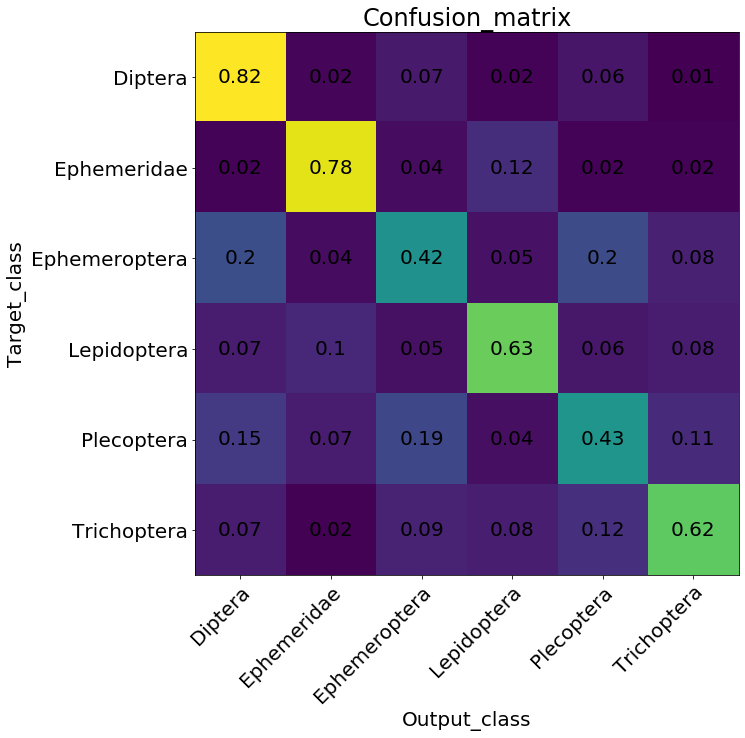

In [12]:
create_confusion_matrix(validation_matrix, ntests, args.labels, args.figure_root, save=args.save_fig)

In [13]:
each_df = compute_each_size_df(result, x_all, y_all)
if args.save_df is True:
    each_df.to_csv(pj(args.figure_root, "each_size_df.csv"))
each_df

,Accuracy,Insect_size
0,True,5632
1,True,13125
2,True,12190
3,True,4148
4,True,323
...,...,...
1319,True,2070
1320,False,3408
1321,False,4224
1322,False,5151


In [14]:
all_df = compute_all_size_df(each_df)
if args.save_df is True:
    all_df.to_csv(pj(args.figure_root, "all_size_df.csv"))
all_df

,order,Accuracy,Insect_size
0,1.0,0.000000,2.000000
1,7.0,0.916667,205.833333
2,8.0,0.705882,395.039216
3,9.0,0.535433,770.850394
4,10.0,0.423729,1504.529661
5,11.0,0.565517,2941.368966
6,12.0,0.780645,5934.145161
7,13.0,0.822967,11264.789474
8,14.0,0.628205,22344.653846
9,15.0,0.700000,34865.400000


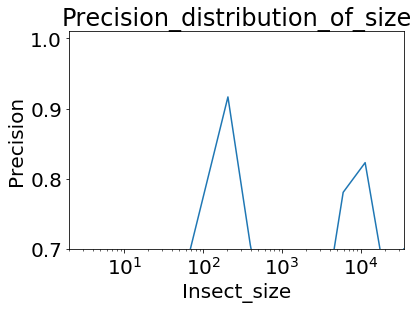

In [15]:
plot_df_distrib_size(all_df, args.figure_root, save=args.save_fig)

### Load and Test model